In [1]:
!pip install torch
!pip install pytorch-lightning
!pip install pytorch-forecasting torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 33.4 MB/s eta 0:00:00


In [2]:
!pip install prophet
!pip install holidays
!pip install pycountry
!pip install plotly seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 12.4 MB/s eta 0:00:00


In [3]:
!pip install pycountry

In [4]:
import os
import pandas as pd
import numpy as np
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go

from datetime import date, timedelta, datetime
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import holidays

import pycountry
import plotly.express as px
from collections import namedtuple

import warnings
warnings.simplefilter('ignore')

In [5]:
# https://github.com/CSSEGISandData/COVID-19
myfile = requests.get('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
open('data', 'wb').write(myfile.content)
confirmed_global_df = pd.read_csv('data')
confirmed_global_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
285,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
286,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945
287,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,343012,343012,343079,343079,343079,343135,343135,343135,343135,343135


In [6]:
# Thanks to https://www.kaggle.com/corochann/covid-19-current-situation-on-august
def _convert_date_str(df):
    try:
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]
    except:
        print('_convert_date_str failed with %y, try %Y')
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%Y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]

_convert_date_str(confirmed_global_df)
confirmed_global_df

,Province/State,Country/Region,Lat,Long,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2023-02-28,2023-03-01,2023-03-02,2023-03-03,2023-03-04,2023-03-05,2023-03-06,2023-03-07,2023-03-08,2023-03-09
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
285,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
286,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945
287,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,343012,343012,343079,343079,343079,343135,343135,343135,343135,343135


In [7]:
# Thanks to https://www.kaggle.com/corochann/covid-19-current-situation-on-august
df = confirmed_global_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='ConfirmedCases')

In [8]:
df

,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0
...,...,...,...,...,...,...
330322,NaN,West Bank and Gaza,31.952200,35.233200,2023-03-09,703228
330323,NaN,Winter Olympics 2022,39.904200,116.407400,2023-03-09,535
330324,NaN,Yemen,15.552727,48.516388,2023-03-09,11945
330325,NaN,Zambia,-13.133897,27.849332,2023-03-09,343135


In [9]:
df["Country/Region"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Gua

In [10]:
# Convert name of countries to ISO 3166
df["Country/Region"].replace({'Korea, South': 'Korea, Republic of'}, inplace=True)
df["Country/Region"].replace({'Russia': 'Russian Federation'}, inplace=True)
df["Country/Region"].replace({'US': 'United States'}, inplace=True)

In [11]:
df['Date'] = pd.to_datetime(df['Date'], format = "%Y-%m-%d")
df

,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0
...,...,...,...,...,...,...
330322,NaN,West Bank and Gaza,31.952200,35.233200,2023-03-09,703228
330323,NaN,Winter Olympics 2022,39.904200,116.407400,2023-03-09,535
330324,NaN,Yemen,15.552727,48.516388,2023-03-09,11945
330325,NaN,Zambia,-13.133897,27.849332,2023-03-09,343135


In [82]:
# Version 32 - selection dates from 2020-12-01
# Version 33-63 - without this filter
# Version 64 - selection dates from 2021-09-01
df = df[df['Date'] >= datetime.strptime('2021-09-01', "%Y-%m-%d")]
df

,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases
169932,NaN,Afghanistan,33.939110,67.709953,2021-09-01,153260
169933,NaN,Albania,41.153300,20.168300,2021-09-01,147369
169934,NaN,Algeria,28.033900,1.659600,2021-09-01,196527
169935,NaN,Andorra,42.506300,1.521800,2021-09-01,15046
169936,NaN,Angola,-11.202700,17.873900,2021-09-01,47781
...,...,...,...,...,...,...
330322,NaN,West Bank and Gaza,31.952200,35.233200,2023-03-09,703228
330323,NaN,Winter Olympics 2022,39.904200,116.407400,2023-03-09,535
330324,NaN,Yemen,15.552727,48.516388,2023-03-09,11945
330325,NaN,Zambia,-13.133897,27.849332,2023-03-09,343135


In [14]:
# Assuming `Date` is a datetime column and `ConfirmedCases` is numeric
df2 = df.groupby(["Date", "Country/Region"], as_index=False)[["ConfirmedCases"]].sum()

In [15]:
df_countries = df2['Country/Region'].unique()
df_countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Gua

In [16]:
latest_date = df2['Date'].max()
latest_date

Timestamp('2023-03-09 00:00:00')

In [18]:
import kagglehub
path = kagglehub.dataset_download("vbmokin/covid19-holidays-of-countries")
print("Path to dataset files:", path)

100%|██████████| 80.6k/80.6k [00:00<00:00, 33.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/vbmokin/covid19-holidays-of-countries/versions/6


In [19]:
# Define the path to the CSV file
file_path = '/root/.cache/kagglehub/datasets/vbmokin/covid19-holidays-of-countries/versions/6/holidays_df_of_70_countries_for_covid_19_2022_Temporary.csv'
holidays_df = pd.read_csv(file_path)
holidays_df

,ds_holidays,holiday,ds,country,code,country_official_name,lower_window,upper_window,prior_scale,source
0,2020-02-24,Día de Carnaval [Carnival's Day],2020-03-02,Argentina,AR,Argentine Republic,-3,3,10,https://github.com/dr-prodigy/python-holidays
1,2020-02-25,Día de Carnaval [Carnival's Day],2020-03-03,Argentina,AR,Argentine Republic,-3,3,10,https://github.com/dr-prodigy/python-holidays
2,2020-03-24,Día Nacional de la Memoria por la Verdad y la ...,2020-03-31,Argentina,AR,Argentine Republic,-3,3,10,https://github.com/dr-prodigy/python-holidays
3,2020-04-09,Semana Santa (Jueves Santo) [Holy day (Holy T...,2020-04-16,Argentina,AR,Argentine Republic,-3,3,10,https://github.com/dr-prodigy/python-holidays
4,2020-04-10,Semana Santa (Viernes Santo) [Holy day (Holy ...,2020-04-17,Argentina,AR,Argentine Republic,-3,3,10,https://github.com/dr-prodigy/python-holidays
...,...,...,...,...,...,...,...,...,...,...
2593,2021-05-09,Victory Day and Commemoration of the Fallen He...,2021-05-16,Moldova,MD,Republic of Moldova,-3,3,10,https://en.wikipedia.org/wiki/Public_holidays_...
2594,2021-06-01,Children's Day,2021-06-08,Moldova,MD,Republic of Moldova,-3,3,10,https://en.wikipedia.org/wiki/Public_holidays_...
2595,2021-08-27,Independence Day,2021-09-03,Moldova,MD,Republic of Moldova,-3,3,10,https://en.wikipedia.org/wiki/Public_holidays_...
2596,2021-08-31,National Language Day,2021-09-07,Moldova,MD,Republic of Moldova,-3,3,10,https://en.wikipedia.org/wiki/Public_holidays_...


In [20]:
holidays_df['country'].unique()

array(['Argentina', 'Austria', 'Australia', 'Bangladesh', 'Belgium',
       'Bulgaria', 'Burundi', 'Brazil', 'Belarus', 'Canada',
       'Switzerland', 'Chile', 'China', 'Colombia', 'Czechia', 'Germany',
       'Denmark', 'Dominican Republic', 'Estonia', 'Egypt', 'Spain',
       'Finland', 'France', 'United Kingdom', 'Greece', 'Honduras',
       'Croatia', 'Hungary', 'Indonesia', 'Ireland', 'Israel', 'India',
       'Iceland', 'Italy', 'Japan', 'Kenya', 'Korea, Republic of',
       'Lithuania', 'Luxembourg', 'Latvia', 'Morocco', 'Mexico',
       'Malaysia', 'Nigeria', 'Nicaragua', 'Netherlands', 'Norway',
       'New Zealand', 'Peru', 'Philippines', 'Pakistan', 'Poland',
       'Portugal', 'Paraguay', 'Romania', 'Serbia', 'Russian Federation',
       'Sweden', 'Singapore', 'Slovenia', 'Slovakia', 'Thailand',
       'Turkey', 'Ukraine', 'United States', 'Viet Nam', 'South Africa',
       'Georgia', 'Albania', 'Moldova'], dtype=object)

In [21]:
holidays_df_code_countries = holidays_df['code'].unique()
holidays_df_code_countries

array(['AR', 'AT', 'AU', 'BD', 'BE', 'BG', 'BI', 'BR', 'BY', 'CA', 'CH',
       'CL', 'CN', 'CO', 'CZ', 'DE', 'DK', 'DO', 'EE', 'EG', 'ES', 'FI',
       'FR', 'GB', 'GR', 'HN', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS',
       'IT', 'JP', 'KE', 'KR', 'LT', 'LU', 'LV', 'MA', 'MX', 'MY', 'NG',
       'NI', 'NL', 'NO', 'NZ', 'PE', 'PH', 'PK', 'PL', 'PT', 'PY', 'RO',
       'RS', 'RU', 'SE', 'SG', 'SI', 'SK', 'TH', 'TR', 'UA', 'US', 'VN',
       'ZA', 'GE', 'AL', 'MD'], dtype=object)

In [22]:
def dict_code_countries_with_holidays(list_name_countries: list,
                                      holidays_df: pd.DataFrame()):
    countries = {}
    dataset_all_countries = list(holidays_df['code'].unique())
    list_name_countries_identificated = []
    list_name_countries_not_identificated = []
    for country in list_name_countries:
        try:
            country_id = pycountry.countries.get(alpha_2=country)
            if country_id.alpha_2 in dataset_all_countries:
                countries[country] = country_id.alpha_2
        except AttributeError:
            try:
                country_id = pycountry.countries.get(name=country)
                if country_id.alpha_2 in dataset_all_countries:
                    countries[country] = country_id.alpha_2
            except AttributeError:
                try:
                    country_id = pycountry.countries.get(official_name=country)
                    if country_id.alpha_2 in dataset_all_countries:
                        countries[country] = country_id.alpha_2
                except AttributeError:
                    try:
                        country_id = pycountry.countries.get(common_name=country)
                        if country_id.alpha_2 in dataset_all_countries:
                            countries[country] = country_id.alpha_2
                    except AttributeError:
                        try:
                            country_id = pycountry.countries.get(alpha_3=country)
                            if country_id.alpha_2 in dataset_all_countries:
                                countries[country] = country_id.alpha_2
                        except AttributeError:
                            list_name_countries_not_identificated.append(country)
    holidays_df_identificated = holidays_df[holidays_df['code'].isin(countries.values())]

    print(f'Thus, the dataset has holidays in {len(countries)} countries from your list with {len(list_name_countries)} countries')
    if len(countries) == len(dataset_all_countries):
        print('All available in this dataset holiday data is used')
    else:
        print("Holidays are available in the dataset for such countries (if there are countries from your list, then it's recommended making changes to the list)")
        print(np.array(holidays_df[~holidays_df['code'].isin(countries.values())].country_official_name.unique()))

    return countries, holidays_df_identificated

In [23]:
countries_dict, holidays_df = dict_code_countries_with_holidays(df_countries,holidays_df)

Thus, the dataset has holidays in 69 countries from your list with 201 countries
Holidays are available in the dataset for such countries (if there are countries from your list, then it's recommended making changes to the list)
['Republic of Turkey']


In [24]:
def adaption_df_to_holidays_df_for_prophet(df, col, countries_dict):
    df = df[df[col].isin(list(countries_dict.keys()))].reset_index(drop=True)
    df['iso_alpha'] = None
    for key, value in countries_dict.items():
        df.loc[df[col] == key, 'iso_alpha'] = value

    return df

In [25]:
holidays_df

,ds_holidays,holiday,ds,country,code,country_official_name,lower_window,upper_window,prior_scale,source
0,2020-02-24,Día de Carnaval [Carnival's Day],2020-03-02,Argentina,AR,Argentine Republic,-3,3,10,https://github.com/dr-prodigy/python-holidays
1,2020-02-25,Día de Carnaval [Carnival's Day],2020-03-03,Argentina,AR,Argentine Republic,-3,3,10,https://github.com/dr-prodigy/python-holidays
2,2020-03-24,Día Nacional de la Memoria por la Verdad y la ...,2020-03-31,Argentina,AR,Argentine Republic,-3,3,10,https://github.com/dr-prodigy/python-holidays
3,2020-04-09,Semana Santa (Jueves Santo) [Holy day (Holy T...,2020-04-16,Argentina,AR,Argentine Republic,-3,3,10,https://github.com/dr-prodigy/python-holidays
4,2020-04-10,Semana Santa (Viernes Santo) [Holy day (Holy ...,2020-04-17,Argentina,AR,Argentine Republic,-3,3,10,https://github.com/dr-prodigy/python-holidays
...,...,...,...,...,...,...,...,...,...,...
2593,2021-05-09,Victory Day and Commemoration of the Fallen He...,2021-05-16,Moldova,MD,Republic of Moldova,-3,3,10,https://en.wikipedia.org/wiki/Public_holidays_...
2594,2021-06-01,Children's Day,2021-06-08,Moldova,MD,Republic of Moldova,-3,3,10,https://en.wikipedia.org/wiki/Public_holidays_...
2595,2021-08-27,Independence Day,2021-09-03,Moldova,MD,Republic of Moldova,-3,3,10,https://en.wikipedia.org/wiki/Public_holidays_...
2596,2021-08-31,National Language Day,2021-09-07,Moldova,MD,Republic of Moldova,-3,3,10,https://en.wikipedia.org/wiki/Public_holidays_...


In [26]:
df2 = adaption_df_to_holidays_df_for_prophet(df2, 'Country/Region', countries_dict)
df2.columns = ['Date', 'Country', 'Confirmed', 'iso_alpha']
df2

,Date,Country,Confirmed,iso_alpha
0,2021-09-01,Albania,147369,AL
1,2021-09-01,Argentina,5190948,AR
2,2021-09-01,Australia,56560,AU
3,2021-09-01,Austria,683900,AT
4,2021-09-01,Bangladesh,1503680,BD
...,...,...,...,...
38290,2023-03-09,Thailand,4728182,TH
38291,2023-03-09,Ukraine,5711929,UA
38292,2023-03-09,United Kingdom,24658705,GB
38293,2023-03-09,United States,103802702,US


In [27]:
print("Number of countries/regions with data: " + str(len(df2.Country.unique())))

Number of countries/regions with data: 69


In [28]:
df2.describe()

,Date,Confirmed
count,38295,3.829500e+04
mean,2022-06-05 00:00:00,6.322988e+06
min,2021-09-01 00:00:00,3.646000e+03
25%,2022-01-17 00:00:00,7.225545e+05
50%,2022-06-05 00:00:00,2.152368e+06
75%,2022-10-22 00:00:00,5.198734e+06
max,2023-03-09 00:00:00,1.038027e+08
std,NaN,1.249988e+07


In [29]:
df2.head()

,Date,Country,Confirmed,iso_alpha
0,2021-09-01,Albania,147369,AL
1,2021-09-01,Argentina,5190948,AR
2,2021-09-01,Australia,56560,AU
3,2021-09-01,Austria,683900,AT
4,2021-09-01,Bangladesh,1503680,BD


In [30]:
df2.tail()

,Date,Country,Confirmed,iso_alpha
38290,2023-03-09,Thailand,4728182,TH
38291,2023-03-09,Ukraine,5711929,UA
38292,2023-03-09,United Kingdom,24658705,GB
38293,2023-03-09,United States,103802702,US
38294,2023-03-09,Vietnam,11526994,VN


In [31]:
lower_window_list = [0, -1, -2, -3]
upper_window_list = [0, 1, 2, 3]
prior_scale_list = [0.05, 0.5, 1, 15]

In [32]:
def convert10_base4(n):
    alphabet = "0123"
    if n < 4:
        return alphabet[n]
    else:
        return (convert10_base4(n // 4) + alphabet[n % 4]).format('4f')

In [33]:
days_to_forecast = 7
days_to_forecast_for_evalution = 7
first_forecasted_date = sorted(list(set(df2['Date'].values)))[-days_to_forecast]
print('The first date to perform forecasts for evaluation is: ' + str(first_forecasted_date))

The first date to perform forecasts for evaluation is: 2023-03-03T00:00:00.000000000


In [34]:
print('The end date to perform forecasts in future for is: ' + (df2['Date'].max() + timedelta(days = days_to_forecast)).strftime("%Y-%m-%d"))

The end date to perform forecasts in future for is: 2023-03-16


In [35]:
confirmed_df = df2[['Date', 'Country', 'Confirmed', 'iso_alpha']]
confirmed_df

,Date,Country,Confirmed,iso_alpha
0,2021-09-01,Albania,147369,AL
1,2021-09-01,Argentina,5190948,AR
2,2021-09-01,Australia,56560,AU
3,2021-09-01,Austria,683900,AT
4,2021-09-01,Bangladesh,1503680,BD
...,...,...,...,...
38290,2023-03-09,Thailand,4728182,TH
38291,2023-03-09,Ukraine,5711929,UA
38292,2023-03-09,United Kingdom,24658705,GB
38293,2023-03-09,United States,103802702,US


In [36]:
all_countries = confirmed_df['Country'].unique()
all_countries

array(['Albania', 'Argentina', 'Australia', 'Austria', 'Bangladesh',
       'Belarus', 'Belgium', 'Brazil', 'Bulgaria', 'Burundi', 'Canada',
       'Chile', 'China', 'Colombia', 'Croatia', 'Czechia', 'Denmark',
       'Dominican Republic', 'Egypt', 'Estonia', 'Finland', 'France',
       'Georgia', 'Germany', 'Greece', 'Honduras', 'Hungary', 'Iceland',
       'India', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Kenya', 'Korea, Republic of', 'Latvia', 'Lithuania', 'Luxembourg',
       'Malaysia', 'Mexico', 'Moldova', 'Morocco', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Nigeria', 'Norway', 'Pakistan',
       'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania',
       'Russian Federation', 'Serbia', 'Singapore', 'Slovakia',
       'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland',
       'Thailand', 'Ukraine', 'United Kingdom', 'United States',
       'Vietnam'], dtype=object)

In [37]:
n = 64

In [40]:
def make_forecasts(all_countries, confirmed_df, holidays_df, days_to_forecast, days_to_forecast_for_evalution, first_forecasted_date):
    # Thanks to https://www.kaggle.com/vbmokin/covid-19-in-ukraine-prophet-holidays-tuning

    def eval_error(forecast_df, country_df_val, first_forecasted_date, title):
        # Evaluate forecasts with validation set val_df and calculaction and printing with title the relative error
        forecast_df[forecast_df['yhat'] < 0]['yhat'] = 0
        result_df = forecast_df[(forecast_df['ds'] >= pd.to_datetime(first_forecasted_date))]
        result_val_df = result_df.merge(country_df_val, on=['ds'])
        result_val_df['rel_diff'] = (result_val_df['y'] - result_val_df['yhat']).round().abs()
        relative_error = [sum(result_val_df['rel_diff'].values)*100/result_val_df['y'].sum()]
        return relative_error

    def model_training_forecasting(df, forecast_days, holidays_df=None):
        # Prophet model training and forecasting

        model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False,
                        holidays=holidays_df, changepoint_range=1, changepoint_prior_scale = 0.25)
        model.add_seasonality(name='weekly', period=7, fourier_order=8, mode = 'multiplicative', prior_scale = 0.3)
        #model.add_seasonality(name='triply', period=3, fourier_order=2, mode = 'multiplicative', prior_scale = 0.5)
        model.fit(df)
        future = model.make_future_dataframe(periods=forecast_days)
        forecast = model.predict(future)
        forecast[forecast['yhat'] < 0]['yhat'] = 0
        forecast['yhat_lower'] = forecast['yhat_lower'].round().astype('int')
        forecast['yhat'] = forecast['yhat'].round().astype('int')
        forecast['yhat_upper'] = forecast['yhat_upper'].round().astype('int')

        return model, forecast

    forecast_dfs = []
    relative_errors = []
    cols_w = ['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
              'multiplicative_terms','multiplicative_terms_lower', 'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper']
    cols_h = ['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
              'holidays', 'holidays_lower', 'holidays_upper', 'multiplicative_terms','multiplicative_terms_lower', 'multiplicative_terms_upper', 'weekly',
              'weekly_lower', 'weekly_upper']
    relative_errors_holidays = []
    #forecast_holidays_dfs = []
    #forecast_future_dfs = []
    counter = 0
    results = pd.DataFrame(columns=['Country', 'Country_code', 'Conf_real', 'Conf_pred', 'Conf_pred_h', 'n_h', 'err', 'err_h', 'lower_window', 'upper_window', 'prior_scale', 'how_less, %'])
    w = 0


#for j in range(len(all_countries)):
    for j in range(1): #just 1 country to check
        country = all_countries[j]
        if country in confirmed_df['Country'].values:
            print(f'Country {str(country)} is listed')
            country_df = confirmed_df[confirmed_df['Country'] == country].reset_index(drop=True)
            country_iso_alpha = country_df['iso_alpha'][0]

            # Calc daily values and ignoring zero daily total cases
            country_df['Confirmed'] = country_df['Confirmed'].diff()
            country_df.loc[0,'Confirmed'] = 0
            country_df = country_df[country_df['Confirmed'] > 0].reset_index(drop=True)

            # Selection holidays of country
            country_holidays_df = holidays_df[holidays_df['code'] == country_iso_alpha][['ds', 'holiday', 'lower_window', 'upper_window', 'prior_scale']].reset_index(drop=True)
            country_dfs = []

            # Data preparation for forecast with Prophet
            country_df = country_df[['Date', 'Confirmed']]
            country_df.columns = ['ds','y']

            # Set training and validation datasets
            country_df_future = country_df.copy()
            country_df_val = country_df[(country_df['ds'] >= pd.to_datetime(first_forecasted_date))].copy()
            if country_df_val['y'].sum() > 0:
                # There is data of the last week

                country_df = country_df[(country_df['ds'] < pd.to_datetime(first_forecasted_date))]

                # Without holidays
                # Model training and forecasting without holidays
                model, forecast = model_training_forecasting(country_df, days_to_forecast_for_evalution)
                #fig1 = model.plot_components(forecast)

                # Evaluate forecasts with validation set val_df and calculaction and printing the relative error
                forecast_df = forecast[['ds', 'yhat']].copy()
                relative_errors += eval_error(forecast_df, country_df_val, first_forecasted_date, 'without holidays')

                # With holidays
                # Model training with tuning prior_scale and forecasting
                relative_error_holidays_min = relative_errors[-1]
                number_holidays = len(country_holidays_df[(country_holidays_df['ds'] > '2020-01-21')])
                for i in range(n):
                    parameters_iter = convert10_base4(i).zfill(3)
                    lower_window_i = lower_window_list[int(parameters_iter[0])]
                    upper_window_i = upper_window_list[int(parameters_iter[1])]
                    prior_scale_i = prior_scale_list[int(parameters_iter[2])]
                    country_holidays_df['lower_window'] = lower_window_i
                    country_holidays_df['upper_window'] = upper_window_i
                    country_holidays_df['prior_scale'] = prior_scale_i
                    model_holidays, forecast_holidays = model_training_forecasting(country_df, days_to_forecast_for_evalution, country_holidays_df)

                    # Evaluate forecasts with validation set val_df and calculaction and printing the relative error
                    forecast_holidays_df = forecast_holidays[['ds', 'yhat']].copy()
                    relative_error_holidays = eval_error(forecast_holidays_df, country_df_val, first_forecasted_date, 'with holidays impact')

                    # Save results
                    if i == 0:
                        relative_error_holidays_min = relative_error_holidays
                        forecast_holidays_df_best = forecast_holidays[cols_h]
                        model_holidays_best = model_holidays
                        lower_window_best = lower_window_i
                        upper_window_best = upper_window_i
                        prior_scale_best = prior_scale_i
                    elif (relative_error_holidays[0] < relative_error_holidays_min[0]):
                        relative_error_holidays_min = relative_error_holidays
                        forecast_holidays_df_best = forecast_holidays[cols_h]
                        model_holidays_best = model_holidays
                        lower_window_best = lower_window_i
                        upper_window_best = upper_window_i
                        prior_scale_best = prior_scale_i
                    print('i =',i,' from',n,':  lower_window =', lower_window_i, 'upper_window =',upper_window_i, 'prior_scale =', prior_scale_i)
                    print('error_holidays =',relative_error_holidays[0], 'err_holidays_min (WAPE)',relative_error_holidays_min[0], '\n')

                # Results visualization
                print('The best errors of model with holidays is', relative_error_holidays_min[0], 'with lower_window =', str(lower_window_best),
                  ' upper_window =', str(upper_window_best), ' prior_scale =', str(prior_scale_best))
                print('The best errors WAPE of model with holidays is', relative_error_holidays_min[0], '\n')
                relative_errors_holidays += relative_error_holidays_min

                # Save results to dataframe with all dates
                forecast_holidays_df_best['country'] = country
                forecast_holidays_df_best.rename(columns={'yhat':'confirmed'}, inplace=True)
                if w == 0:
                    forecast_holidays_dfs = forecast_holidays_df_best.tail(days_to_forecast_for_evalution)
                else:
                    forecast_holidays_dfs = pd.concat([forecast_future_dfs, forecast_holidays_df_best.tail(days_to_forecast_for_evalution)])

                # Forecasting the future
                if relative_errors[-1] < relative_errors_holidays[-1]:
                    # The forecast without taking into account the holidays is the best
                    model_future_best, forecast_future_best = model_training_forecasting(country_df_future, days_to_forecast)
                    forecast_plot = model_future_best.plot(forecast_future_best, ylabel='Confirmed in '+ country + ' (forecasting without holidays)')
                    cols = cols_w
                else:
                    # The forecast taking into account the holidays is the best
                    country_holidays_df['prior_scale'] = prior_scale_best
                    model_future_best, forecast_future_best = model_training_forecasting(country_df_future, days_to_forecast, country_holidays_df)
                    forecast_plot = model_future_best.plot(forecast_future_best, ylabel='Confirmed in '+ country + ' (forecasting with holidays)')
                    cols = cols_h
                # Save forecasting results
                forecast_future_df_best = forecast_future_best[cols]
                forecast_future_df_best['country'] = country
                forecast_future_df_best.rename(columns={'yhat':'confirmed'}, inplace=True)
                if w == 0:
                    forecast_future_dfs = forecast_future_df_best.tail(days_to_forecast)
                else:
                    forecast_future_dfs = pd.concat([forecast_future_dfs, forecast_future_df_best.tail(days_to_forecast)])

                # Save results to dataframe with result for the last date
                results.loc[w,'Country'] = country
                results.loc[w,'Country_code'] = country_iso_alpha
                confirmed_real_last = country_df_val.tail(1)['y'].values[0].astype('int')
                results.loc[w,'Conf_real'] = confirmed_real_last if confirmed_real_last > 0 else 0
                confirmed_pred_last = int(round(forecast_df.tail(1)['yhat'].values[0]))
                results.loc[w,'Conf_pred'] = confirmed_pred_last if confirmed_pred_last > 0 else 0
                confirmed_pred_holidays_last = int(round(forecast_holidays_df_best.tail(1)['confirmed'].values[0], 0))
                results.loc[w,'Conf_pred_h'] = confirmed_pred_holidays_last if confirmed_pred_holidays_last > 0 else 0
                results.loc[w,'n_h'] = number_holidays
                results.loc[w,'err'] = relative_errors[-1]
                results.loc[w,'err_h'] = relative_errors_holidays[-1]
                results.loc[w,'lower_window'] = lower_window_best
                results.loc[w,'upper_window'] = upper_window_best
                results.loc[w,'prior_scale'] = prior_scale_best
                results.loc[w,'how_less, %'] = round((relative_errors[-1]-relative_errors_holidays[-1])*100/relative_errors[-1],1)
                w += 1

                # Output forecasting data
                forecast_future_opt_future = forecast_future_df_best[['ds', 'yhat_lower', 'confirmed', 'yhat_upper']].copy().tail(days_to_forecast)
                forecast_future_opt_future.columns = ['ds', 'confirmed_lower', 'confirmed', 'confirmed_upper']
                display(forecast_future_opt_future)

                # Output plot
                model_future_best.plot_components(forecast_future_best)
            else:
                print(f'Data for country {str(country)} for the last week are missing!\n')
                continue

        else:
            print(f'Country {str(country)} is not listed!')
            continue

    return forecast_holidays_dfs, relative_errors_holidays, forecast_future_dfs, results

DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/xtm91iyg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/gybcihwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76700', 'data', 'file=/tmp/tmp3i9t65l8/xtm91iyg.json', 'init=/tmp/tmp3i9t65l8/gybcihwb.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelmm31un_g/prophet_model-20241027042426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:24:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Country Albania is listed


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/x1o6scei.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/91buctwd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88298', 'data', 'file=/tmp/tmp3i9t65l8/x1o6scei.json', 'init=/tmp/tmp3i9t65l8/91buctwd.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model55amrpgu/prophet_model-20241027042426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:24:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/m8mjggwx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/iq0x8til.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

i = 0  from 64 :  lower_window = 0 upper_window = 0 prior_scale = 0.05
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 51.42857142857143 



04:24:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/1hjh3xdh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/_ir5_vzm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91453', 'data', 'file=/tmp/tmp3i9t65l8/1hjh3xdh.json', 'init=/tmp/tmp3i9t65l8/_ir5_vzm.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelc5cveb1v/prophet_model-20241027042427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 1  from 64 :  lower_window = 0 upper_window = 0 prior_scale = 0.5
error_holidays = 48.57142857142857 err_holidays_min (WAPE) 48.57142857142857 



04:24:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/2q2l281g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/bd2l329_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5802', 'data', 'file=/tmp/tmp3i9t65l8/2q2l281g.json', 'init=/tmp/tmp3i9t65l8/bd2l329_.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelmktmb3zi/prophet_model-20241027042427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 2  from 64 :  lower_window = 0 upper_window = 0 prior_scale = 1
error_holidays = 62.857142857142854 err_holidays_min (WAPE) 48.57142857142857 



04:24:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/nnrhpa_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/7q35xkb0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92391', 'data', 'file=/tmp/tmp3i9t65l8/nnrhpa_r.json', 'init=/tmp/tmp3i9t65l8/7q35xkb0.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelgaeg6a4q/prophet_model-20241027042428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 3  from 64 :  lower_window = 0 upper_window = 0 prior_scale = 15
error_holidays = 62.857142857142854 err_holidays_min (WAPE) 48.57142857142857 



04:24:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/icde5_1_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/23sar3oh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10018', 'data', 'file=/tmp/tmp3i9t65l8/icde5_1_.json', 'init=/tmp/tmp3i9t65l8/23sar3oh.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelixuikh1c/prophet_model-20241027042428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 4  from 64 :  lower_window = 0 upper_window = 1 prior_scale = 0.05
error_holidays = 62.857142857142854 err_holidays_min (WAPE) 48.57142857142857 



04:24:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/hkmyiyyo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/ozuy_l2f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46116', 'data', 'file=/tmp/tmp3i9t65l8/hkmyiyyo.json', 'init=/tmp/tmp3i9t65l8/ozuy_l2f.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelqt1_0x67/prophet_model-20241027042429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 5  from 64 :  lower_window = 0 upper_window = 1 prior_scale = 0.5
error_holidays = 54.285714285714285 err_holidays_min (WAPE) 48.57142857142857 



04:24:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/bed0bp4m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/3tgwiuk5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43088', 'data', 'file=/tmp/tmp3i9t65l8/bed0bp4m.json', 'init=/tmp/tmp3i9t65l8/3tgwiuk5.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelsrxi8pq0/prophet_model-20241027042429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 6  from 64 :  lower_window = 0 upper_window = 1 prior_scale = 1
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 48.57142857142857 



04:24:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/kf41c8vl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/rs5dc_7u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30476', 'data', 'file=/tmp/tmp3i9t65l8/kf41c8vl.json', 'init=/tmp/tmp3i9t65l8/rs5dc_7u.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelyakbw6pv/prophet_model-20241027042430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 7  from 64 :  lower_window = 0 upper_window = 1 prior_scale = 15
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 48.57142857142857 



04:24:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/u7sjm1eh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/6zfa14ya.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25850', 'data', 'file=/tmp/tmp3i9t65l8/u7sjm1eh.json', 'init=/tmp/tmp3i9t65l8/6zfa14ya.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelu7oxmlsi/prophet_model-20241027042430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 8  from 64 :  lower_window = 0 upper_window = 2 prior_scale = 0.05
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 48.57142857142857 



04:24:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/yvf7q5py.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/jwt9r7sf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19585', 'data', 'file=/tmp/tmp3i9t65l8/yvf7q5py.json', 'init=/tmp/tmp3i9t65l8/jwt9r7sf.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model22_pk_1w/prophet_model-20241027042431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 9  from 64 :  lower_window = 0 upper_window = 2 prior_scale = 0.5
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 48.57142857142857 



04:24:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/9f1_wpsv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/9jb17szh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23812', 'data', 'file=/tmp/tmp3i9t65l8/9f1_wpsv.json', 'init=/tmp/tmp3i9t65l8/9jb17szh.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modell6htsej0/prophet_model-20241027042431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 10  from 64 :  lower_window = 0 upper_window = 2 prior_scale = 1
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 48.57142857142857 



04:24:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/t2wc7p1a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/8mwna2d5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95174', 'data', 'file=/tmp/tmp3i9t65l8/t2wc7p1a.json', 'init=/tmp/tmp3i9t65l8/8mwna2d5.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modeli2z9ozbi/prophet_model-20241027042432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 11  from 64 :  lower_window = 0 upper_window = 2 prior_scale = 15
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 48.57142857142857 



04:24:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/yt9i3g7t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/8g3pwim_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6833', 'data', 'file=/tmp/tmp3i9t65l8/yt9i3g7t.json', 'init=/tmp/tmp3i9t65l8/8g3pwim_.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelwsqb3ev6/prophet_model-20241027042432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 12  from 64 :  lower_window = 0 upper_window = 3 prior_scale = 0.05
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 48.57142857142857 



04:24:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/ygxk6_pi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/dss29bcg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8364', 'data', 'file=/tmp/tmp3i9t65l8/ygxk6_pi.json', 'init=/tmp/tmp3i9t65l8/dss29bcg.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modele5rirknv/prophet_model-20241027042433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 13  from 64 :  lower_window = 0 upper_window = 3 prior_scale = 0.5
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 48.57142857142857 



04:24:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/7x9nut73.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/evztsag6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73486', 'data', 'file=/tmp/tmp3i9t65l8/7x9nut73.json', 'init=/tmp/tmp3i9t65l8/evztsag6.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model110cb8kk/prophet_model-20241027042433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 14  from 64 :  lower_window = 0 upper_window = 3 prior_scale = 1
error_holidays = 48.57142857142857 err_holidays_min (WAPE) 48.57142857142857 



04:24:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/_czschq3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/f8m9nxpe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58291', 'data', 'file=/tmp/tmp3i9t65l8/_czschq3.json', 'init=/tmp/tmp3i9t65l8/f8m9nxpe.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelszclj3_g/prophet_model-20241027042434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 15  from 64 :  lower_window = 0 upper_window = 3 prior_scale = 15
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 48.57142857142857 



04:24:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/p2b5tb9a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/nb2z1u29.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75912', 'data', 'file=/tmp/tmp3i9t65l8/p2b5tb9a.json', 'init=/tmp/tmp3i9t65l8/nb2z1u29.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelh5l2kfic/prophet_model-20241027042434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 16  from 64 :  lower_window = -1 upper_window = 0 prior_scale = 0.05
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 48.57142857142857 



04:24:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/o5hppaey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/l3h_xwkd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61385', 'data', 'file=/tmp/tmp3i9t65l8/o5hppaey.json', 'init=/tmp/tmp3i9t65l8/l3h_xwkd.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model73js3ph6/prophet_model-20241027042435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 17  from 64 :  lower_window = -1 upper_window = 0 prior_scale = 0.5
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 48.57142857142857 



04:24:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/6_kl3crn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/n1b1h5ul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3157', 'data', 'file=/tmp/tmp3i9t65l8/6_kl3crn.json', 'init=/tmp/tmp3i9t65l8/n1b1h5ul.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelmqmq77c5/prophet_model-20241027042435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 18  from 64 :  lower_window = -1 upper_window = 0 prior_scale = 1
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 48.57142857142857 



04:24:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/cwwf8tpl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/ix96cwq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85881', 'data', 'file=/tmp/tmp3i9t65l8/cwwf8tpl.json', 'init=/tmp/tmp3i9t65l8/ix96cwq_.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelk9q36uxp/prophet_model-20241027042436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 19  from 64 :  lower_window = -1 upper_window = 0 prior_scale = 15
error_holidays = 54.285714285714285 err_holidays_min (WAPE) 48.57142857142857 



04:24:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/h6qtm3qw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/uopufj8u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=773', 'data', 'file=/tmp/tmp3i9t65l8/h6qtm3qw.json', 'init=/tmp/tmp3i9t65l8/uopufj8u.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modeloufg3m6x/prophet_model-20241027042437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 20  from 64 :  lower_window = -1 upper_window = 1 prior_scale = 0.05
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 48.57142857142857 



04:24:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/8mnx7u9b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/hpuj0jmw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38307', 'data', 'file=/tmp/tmp3i9t65l8/8mnx7u9b.json', 'init=/tmp/tmp3i9t65l8/hpuj0jmw.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelzx_8__uz/prophet_model-20241027042438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 21  from 64 :  lower_window = -1 upper_window = 1 prior_scale = 0.5
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 48.57142857142857 



04:24:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/_v7zlm4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/rb148_xy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50073', 'data', 'file=/tmp/tmp3i9t65l8/_v7zlm4b.json', 'init=/tmp/tmp3i9t65l8/rb148_xy.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelp3x_xhx6/prophet_model-20241027042438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 22  from 64 :  lower_window = -1 upper_window = 1 prior_scale = 1
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 48.57142857142857 



04:24:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/ivjmiwox.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/iuft2eb7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39633', 'data', 'file=/tmp/tmp3i9t65l8/ivjmiwox.json', 'init=/tmp/tmp3i9t65l8/iuft2eb7.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model5h4o2ag6/prophet_model-20241027042439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 23  from 64 :  lower_window = -1 upper_window = 1 prior_scale = 15
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 48.57142857142857 



04:24:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/ycas7c07.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/28uqw4oo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26128', 'data', 'file=/tmp/tmp3i9t65l8/ycas7c07.json', 'init=/tmp/tmp3i9t65l8/28uqw4oo.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model6glw54_u/prophet_model-20241027042439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 24  from 64 :  lower_window = -1 upper_window = 2 prior_scale = 0.05
error_holidays = 62.857142857142854 err_holidays_min (WAPE) 48.57142857142857 



04:24:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/asrjxjyf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/uks8xtn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44188', 'data', 'file=/tmp/tmp3i9t65l8/asrjxjyf.json', 'init=/tmp/tmp3i9t65l8/uks8xtn6.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model86p5j_hp/prophet_model-20241027042440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 25  from 64 :  lower_window = -1 upper_window = 2 prior_scale = 0.5
error_holidays = 48.57142857142857 err_holidays_min (WAPE) 48.57142857142857 



04:24:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/z8627t8o.json


i = 26  from 64 :  lower_window = -1 upper_window = 2 prior_scale = 1
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 48.57142857142857 



DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/t80dzecj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27371', 'data', 'file=/tmp/tmp3i9t65l8/z8627t8o.json', 'init=/tmp/tmp3i9t65l8/t80dzecj.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modele6betv15/prophet_model-20241027042441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:24:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/84jvcgsu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/nuukfrci.json
DEBUG:cmdstanpy:idx 0


i = 27  from 64 :  lower_window = -1 upper_window = 2 prior_scale = 15
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 48.57142857142857 



DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4980', 'data', 'file=/tmp/tmp3i9t65l8/84jvcgsu.json', 'init=/tmp/tmp3i9t65l8/nuukfrci.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelezg704o3/prophet_model-20241027042441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:24:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/9fieefqp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/mlvdt99h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48864', 'data', 'file=/tmp/tmp3i9t65l8/9fieefqp.json', 'init=/tmp

i = 28  from 64 :  lower_window = -1 upper_window = 3 prior_scale = 0.05
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 48.57142857142857 



04:24:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/hm59rplj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/rqhegefc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10636', 'data', 'file=/tmp/tmp3i9t65l8/hm59rplj.json', 'init=/tmp/tmp3i9t65l8/rqhegefc.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model4p0a7ehn/prophet_model-20241027042443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 29  from 64 :  lower_window = -1 upper_window = 3 prior_scale = 0.5
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 48.57142857142857 



04:24:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/rg38o286.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/97_moqst.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73419', 'data', 'file=/tmp/tmp3i9t65l8/rg38o286.json', 'init=/tmp/tmp3i9t65l8/97_moqst.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelll5kl4f3/prophet_model-20241027042444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 30  from 64 :  lower_window = -1 upper_window = 3 prior_scale = 1
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 48.57142857142857 



04:24:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/cxl3zdt7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/c_013u3k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62977', 'data', 'file=/tmp/tmp3i9t65l8/cxl3zdt7.json', 'init=/tmp/tmp3i9t65l8/c_013u3k.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modeln5j6ssj1/prophet_model-20241027042444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 31  from 64 :  lower_window = -1 upper_window = 3 prior_scale = 15
error_holidays = 54.285714285714285 err_holidays_min (WAPE) 48.57142857142857 



04:24:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/j6ali5hp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/1ou1fdzj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49549', 'data', 'file=/tmp/tmp3i9t65l8/j6ali5hp.json', 'init=/tmp/tmp3i9t65l8/1ou1fdzj.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model0082i7z1/prophet_model-20241027042445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 32  from 64 :  lower_window = -2 upper_window = 0 prior_scale = 0.05
error_holidays = 60.0 err_holidays_min (WAPE) 48.57142857142857 



04:24:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/epyodol6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/3sfm4u3i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27104', 'data', 'file=/tmp/tmp3i9t65l8/epyodol6.json', 'init=/tmp/tmp3i9t65l8/3sfm4u3i.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model6onmqhdy/prophet_model-20241027042445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 33  from 64 :  lower_window = -2 upper_window = 0 prior_scale = 0.5
error_holidays = 62.857142857142854 err_holidays_min (WAPE) 48.57142857142857 



04:24:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/nou9piwh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/4g6rvk_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61735', 'data', 'file=/tmp/tmp3i9t65l8/nou9piwh.json', 'init=/tmp/tmp3i9t65l8/4g6rvk_n.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model6qs_dc_3/prophet_model-20241027042446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 34  from 64 :  lower_window = -2 upper_window = 0 prior_scale = 1
error_holidays = 45.714285714285715 err_holidays_min (WAPE) 45.714285714285715 



04:24:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/f21wkujl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/w83z2b5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79945', 'data', 'file=/tmp/tmp3i9t65l8/f21wkujl.json', 'init=/tmp/tmp3i9t65l8/w83z2b5q.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model355ps2xv/prophet_model-20241027042446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 35  from 64 :  lower_window = -2 upper_window = 0 prior_scale = 15
error_holidays = 48.57142857142857 err_holidays_min (WAPE) 45.714285714285715 



04:24:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/xut9fuvu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/zlw2ujll.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49661', 'data', 'file=/tmp/tmp3i9t65l8/xut9fuvu.json', 'init=/tmp/tmp3i9t65l8/zlw2ujll.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelowkib72q/prophet_model-20241027042447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 36  from 64 :  lower_window = -2 upper_window = 1 prior_scale = 0.05
error_holidays = 45.714285714285715 err_holidays_min (WAPE) 45.714285714285715 



04:24:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/9oqyn4un.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/hoiyiz2k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66224', 'data', 'file=/tmp/tmp3i9t65l8/9oqyn4un.json', 'init=/tmp/tmp3i9t65l8/hoiyiz2k.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modely5k22fbf/prophet_model-20241027042447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 37  from 64 :  lower_window = -2 upper_window = 1 prior_scale = 0.5
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 45.714285714285715 



04:24:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/u1jntr1w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/27vlontj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44488', 'data', 'file=/tmp/tmp3i9t65l8/u1jntr1w.json', 'init=/tmp/tmp3i9t65l8/27vlontj.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelkc404wrt/prophet_model-20241027042448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 38  from 64 :  lower_window = -2 upper_window = 1 prior_scale = 1
error_holidays = 45.714285714285715 err_holidays_min (WAPE) 45.714285714285715 



04:24:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/p8n27yoh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/spumpzga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46024', 'data', 'file=/tmp/tmp3i9t65l8/p8n27yoh.json', 'init=/tmp/tmp3i9t65l8/spumpzga.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model4wzej7gs/prophet_model-20241027042449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 39  from 64 :  lower_window = -2 upper_window = 1 prior_scale = 15
error_holidays = 62.857142857142854 err_holidays_min (WAPE) 45.714285714285715 



04:24:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/1a6kz_ud.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/04wln9s8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61686', 'data', 'file=/tmp/tmp3i9t65l8/1a6kz_ud.json', 'init=/tmp/tmp3i9t65l8/04wln9s8.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelzqny3qad/prophet_model-20241027042450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 40  from 64 :  lower_window = -2 upper_window = 2 prior_scale = 0.05
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 45.714285714285715 



04:24:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/itckdx6m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/fdr9u7ds.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11791', 'data', 'file=/tmp/tmp3i9t65l8/itckdx6m.json', 'init=/tmp/tmp3i9t65l8/fdr9u7ds.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model3v5yo_47/prophet_model-20241027042451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 41  from 64 :  lower_window = -2 upper_window = 2 prior_scale = 0.5
error_holidays = 62.857142857142854 err_holidays_min (WAPE) 45.714285714285715 



04:24:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/3m8ft2uz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/f1xccduk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=999', 'data', 'file=/tmp/tmp3i9t65l8/3m8ft2uz.json', 'init=/tmp/tmp3i9t65l8/f1xccduk.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modellb9df9wz/prophet_model-20241027042451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 42  from 64 :  lower_window = -2 upper_window = 2 prior_scale = 1
error_holidays = 60.0 err_holidays_min (WAPE) 45.714285714285715 



04:24:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/sikqmhtu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/v7ngomvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66507', 'data', 'file=/tmp/tmp3i9t65l8/sikqmhtu.json', 'init=/tmp/tmp3i9t65l8/v7ngomvh.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model3tc9so54/prophet_model-20241027042452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 43  from 64 :  lower_window = -2 upper_window = 2 prior_scale = 15
error_holidays = 54.285714285714285 err_holidays_min (WAPE) 45.714285714285715 



04:24:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/6ypk7ydq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/axca172b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81324', 'data', 'file=/tmp/tmp3i9t65l8/6ypk7ydq.json', 'init=/tmp/tmp3i9t65l8/axca172b.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modely5ean0sl/prophet_model-20241027042453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 44  from 64 :  lower_window = -2 upper_window = 3 prior_scale = 0.05
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 45.714285714285715 



04:24:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/4s6vnpuq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/qbye_iuw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8790', 'data', 'file=/tmp/tmp3i9t65l8/4s6vnpuq.json', 'init=/tmp/tmp3i9t65l8/qbye_iuw.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelp81t150j/prophet_model-20241027042453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 45  from 64 :  lower_window = -2 upper_window = 3 prior_scale = 0.5
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 45.714285714285715 



04:24:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/ajricyrs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/wuimvfjd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79557', 'data', 'file=/tmp/tmp3i9t65l8/ajricyrs.json', 'init=/tmp/tmp3i9t65l8/wuimvfjd.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelv8wqm4ch/prophet_model-20241027042454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 46  from 64 :  lower_window = -2 upper_window = 3 prior_scale = 1
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 45.714285714285715 



04:24:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/xl3hfmdm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/27tmk7l8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25881', 'data', 'file=/tmp/tmp3i9t65l8/xl3hfmdm.json', 'init=/tmp/tmp3i9t65l8/27tmk7l8.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model8cayvxdf/prophet_model-20241027042455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 47  from 64 :  lower_window = -2 upper_window = 3 prior_scale = 15
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 45.714285714285715 



04:24:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/ug0383zk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/equc40ie.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59719', 'data', 'file=/tmp/tmp3i9t65l8/ug0383zk.json', 'init=/tmp/tmp3i9t65l8/equc40ie.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelz9hoxl4r/prophet_model-20241027042455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 48  from 64 :  lower_window = -3 upper_window = 0 prior_scale = 0.05
error_holidays = 54.285714285714285 err_holidays_min (WAPE) 45.714285714285715 



04:24:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/e2t6s3ah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/bfecmm8q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23067', 'data', 'file=/tmp/tmp3i9t65l8/e2t6s3ah.json', 'init=/tmp/tmp3i9t65l8/bfecmm8q.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelx9y_z8gd/prophet_model-20241027042456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 49  from 64 :  lower_window = -3 upper_window = 0 prior_scale = 0.5
error_holidays = 42.857142857142854 err_holidays_min (WAPE) 42.857142857142854 



04:24:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/ukgznwq2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/q5jzchil.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51437', 'data', 'file=/tmp/tmp3i9t65l8/ukgznwq2.json', 'init=/tmp/tmp3i9t65l8/q5jzchil.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelyw69haqu/prophet_model-20241027042456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 50  from 64 :  lower_window = -3 upper_window = 0 prior_scale = 1
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 42.857142857142854 



04:24:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/6xh6598k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/hw4iuav4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54486', 'data', 'file=/tmp/tmp3i9t65l8/6xh6598k.json', 'init=/tmp/tmp3i9t65l8/hw4iuav4.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelxhl3ftll/prophet_model-20241027042457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 51  from 64 :  lower_window = -3 upper_window = 0 prior_scale = 15
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 42.857142857142854 



04:24:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/gk0pijnx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/odatqjwo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22510', 'data', 'file=/tmp/tmp3i9t65l8/gk0pijnx.json', 'init=/tmp/tmp3i9t65l8/odatqjwo.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modeldahr9lnq/prophet_model-20241027042458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 52  from 64 :  lower_window = -3 upper_window = 1 prior_scale = 0.05
error_holidays = 65.71428571428571 err_holidays_min (WAPE) 42.857142857142854 



04:24:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/qlrdcu51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/moxjpf7h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35493', 'data', 'file=/tmp/tmp3i9t65l8/qlrdcu51.json', 'init=/tmp/tmp3i9t65l8/moxjpf7h.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelretgp97x/prophet_model-20241027042458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 53  from 64 :  lower_window = -3 upper_window = 1 prior_scale = 0.5
error_holidays = 31.428571428571427 err_holidays_min (WAPE) 31.428571428571427 



04:24:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/cc_ev29n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/mwgpa8w0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87303', 'data', 'file=/tmp/tmp3i9t65l8/cc_ev29n.json', 'init=/tmp/tmp3i9t65l8/mwgpa8w0.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modeli9m5md6c/prophet_model-20241027042459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 54  from 64 :  lower_window = -3 upper_window = 1 prior_scale = 1
error_holidays = 48.57142857142857 err_holidays_min (WAPE) 31.428571428571427 



04:24:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/h1eeppea.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/uew_yq3o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47797', 'data', 'file=/tmp/tmp3i9t65l8/h1eeppea.json', 'init=/tmp/tmp3i9t65l8/uew_yq3o.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modely4f67x87/prophet_model-20241027042500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:25:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 55  from 64 :  lower_window = -3 upper_window = 1 prior_scale = 15
error_holidays = 54.285714285714285 err_holidays_min (WAPE) 31.428571428571427 



04:25:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/fpxqhoxf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/l88ggw3f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90325', 'data', 'file=/tmp/tmp3i9t65l8/fpxqhoxf.json', 'init=/tmp/tmp3i9t65l8/l88ggw3f.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model47l09k3x/prophet_model-20241027042500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:25:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 56  from 64 :  lower_window = -3 upper_window = 2 prior_scale = 0.05
error_holidays = 51.42857142857143 err_holidays_min (WAPE) 31.428571428571427 



04:25:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/du5hxq6i.json


i = 57  from 64 :  lower_window = -3 upper_window = 2 prior_scale = 0.5
error_holidays = 42.857142857142854 err_holidays_min (WAPE) 31.428571428571427 



DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/twc4exbj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80585', 'data', 'file=/tmp/tmp3i9t65l8/du5hxq6i.json', 'init=/tmp/tmp3i9t65l8/twc4exbj.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_model989do2ox/prophet_model-20241027042502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:25:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:25:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/gf4rve3u.json


i = 58  from 64 :  lower_window = -3 upper_window = 2 prior_scale = 1
error_holidays = 54.285714285714285 err_holidays_min (WAPE) 31.428571428571427 



DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/dnp_x47g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27713', 'data', 'file=/tmp/tmp3i9t65l8/gf4rve3u.json', 'init=/tmp/tmp3i9t65l8/dnp_x47g.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelj4_01t_h/prophet_model-20241027042503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:25:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:25:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/zt2750lq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/9yijcqvr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

i = 59  from 64 :  lower_window = -3 upper_window = 2 prior_scale = 15
error_holidays = 48.57142857142857 err_holidays_min (WAPE) 31.428571428571427 



04:25:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/f9l0tocf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/ygljkgwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77213', 'data', 'file=/tmp/tmp3i9t65l8/f9l0tocf.json', 'init=/tmp/tmp3i9t65l8/ygljkgwb.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelfztexjdn/prophet_model-20241027042504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:25:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 60  from 64 :  lower_window = -3 upper_window = 3 prior_scale = 0.05
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 31.428571428571427 



04:25:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/emw0ltqv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/qvux1iz8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75768', 'data', 'file=/tmp/tmp3i9t65l8/emw0ltqv.json', 'init=/tmp/tmp3i9t65l8/qvux1iz8.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelgmltzif8/prophet_model-20241027042505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:25:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 61  from 64 :  lower_window = -3 upper_window = 3 prior_scale = 0.5
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 31.428571428571427 



04:25:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/oytkkj4s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/dhacy41h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79255', 'data', 'file=/tmp/tmp3i9t65l8/oytkkj4s.json', 'init=/tmp/tmp3i9t65l8/dhacy41h.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modelcyft4_q9/prophet_model-20241027042506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:25:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 62  from 64 :  lower_window = -3 upper_window = 3 prior_scale = 1
error_holidays = 45.714285714285715 err_holidays_min (WAPE) 31.428571428571427 



04:25:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/y7h3fdvy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3i9t65l8/fy2d3gzc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42776', 'data', 'file=/tmp/tmp3i9t65l8/y7h3fdvy.json', 'init=/tmp/tmp3i9t65l8/fy2d3gzc.json', 'output', 'file=/tmp/tmp3i9t65l8/prophet_modeliblqs8nj/prophet_model-20241027042507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:25:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


i = 63  from 64 :  lower_window = -3 upper_window = 3 prior_scale = 15
error_holidays = 57.142857142857146 err_holidays_min (WAPE) 31.428571428571427 

The best errors of model with holidays is 31.428571428571427 with lower_window = -3  upper_window = 1  prior_scale = 0.5
The best errors WAPE of model with holidays is 31.428571428571427 



04:25:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,confirmed_lower,confirmed,confirmed_upper
489,2023-03-10,-326,9,325
490,2023-03-11,-294,8,330
491,2023-03-12,-316,8,326
492,2023-03-13,-307,4,322
493,2023-03-14,-314,8,365
494,2023-03-15,-342,9,322
495,2023-03-16,-320,7,331


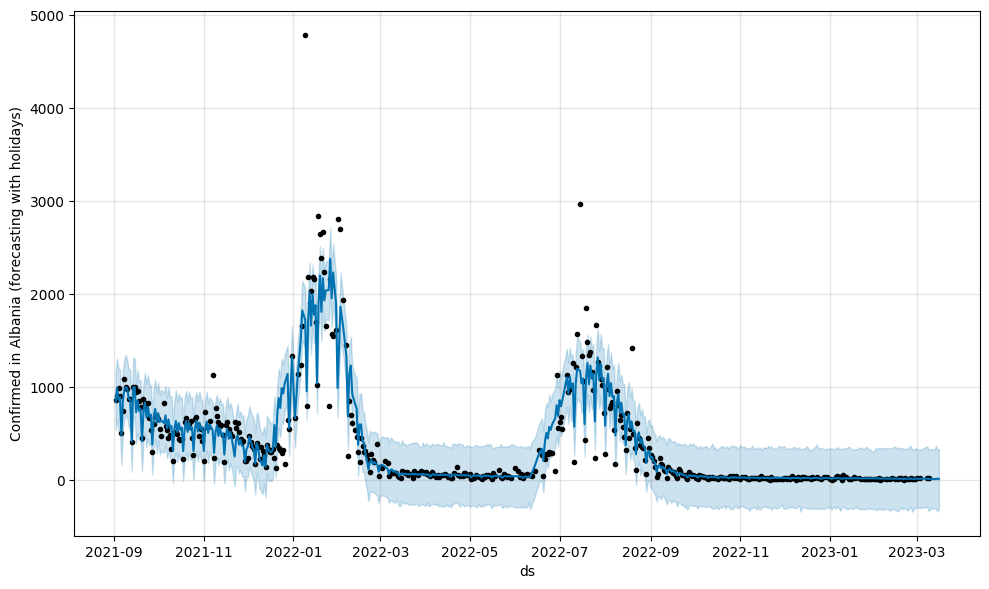

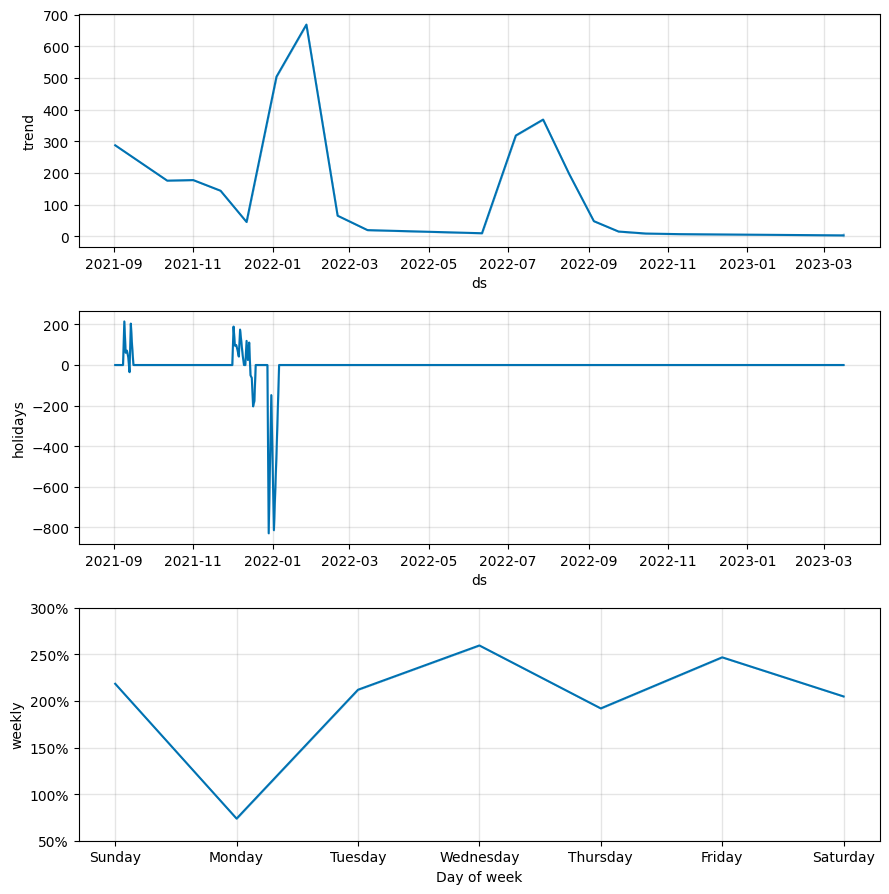

In [41]:
forecast_holidays_dfs, relative_errors_holidays, forecast_future_dfs, results = make_forecasts(all_countries, confirmed_df, holidays_df,
                                                                                               days_to_forecast, days_to_forecast_for_evalution, first_forecasted_date)

In [42]:
forecast_future_dfs

,ds,trend,confirmed,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,country
489,2023-03-10,2.652521,9,-326,325,2.652521,2.652521,0.0,0.0,0.0,0.0,0.0,0.0,2.467348,2.467348,2.467348,2.467348,2.467348,2.467348,Albania
490,2023-03-11,2.621390,8,-294,330,2.621390,2.621390,0.0,0.0,0.0,0.0,0.0,0.0,2.047799,2.047799,2.047799,2.047799,2.047799,2.047799,Albania
491,2023-03-12,2.590258,8,-316,326,2.590258,2.590258,0.0,0.0,0.0,0.0,0.0,0.0,2.183639,2.183639,2.183639,2.183639,2.183639,2.183639,Albania
492,2023-03-13,2.559127,4,-307,322,2.559127,2.559127,0.0,0.0,0.0,0.0,0.0,0.0,0.737275,0.737275,0.737275,0.737275,0.737275,0.737275,Albania
493,2023-03-14,2.527996,8,-314,365,2.030849,3.238656,0.0,0.0,0.0,0.0,0.0,0.0,2.119538,2.119538,2.119538,2.119538,2.119538,2.119538,Albania
494,2023-03-15,2.496865,9,-342,322,0.739408,5.571965,0.0,0.0,0.0,0.0,0.0,0.0,2.594599,2.594599,2.594599,2.594599,2.594599,2.594599,Albania
495,2023-03-16,2.465734,7,-320,331,-0.938674,9.814063,0.0,0.0,0.0,0.0,0.0,0.0,1.919311,1.919311,1.919311,1.919311,1.919311,1.919311,Albania


In [45]:
pd.set_option('display.max_rows', 75)

In [46]:
print('Forecasting results')
display(results.sort_values(by=['err_h'], ascending=True))

Forecasting results


,Country,Country_code,Conf_real,Conf_pred,Conf_pred_h,n_h,err,err_h,lower_window,upper_window,prior_scale,"how_less, %"
0,Albania,AL,14,6,12,28,62.857143,31.428571,-3,1,0.5,50.0


In [47]:
df_h_impact = results[results['how_less, %'] > 1]
if len(df_h_impact) > 0:
    print('Countries with the impact of holidays')
    display(df_h_impact.sort_values(by=['how_less, %'], ascending=False))
    print('Number of these countries is', len(df_h_impact))

Countries with the impact of holidays


,Country,Country_code,Conf_real,Conf_pred,Conf_pred_h,n_h,err,err_h,lower_window,upper_window,prior_scale,"how_less, %"
0,Albania,AL,14,6,12,28,62.857143,31.428571,-3,1,0.5,50.0


Number of these countries is 1


In [48]:
df_h_non_impact = results[results['how_less, %'] < -10]
if len(df_h_non_impact) > 0:
    print('Countries without the impact of holidays')
    display(df_h_non_impact.sort_values(by=['how_less, %'], ascending=False))
    print('Number of these countries is', len(df_h_non_impact))

In [49]:
df_neutral = results[(results['how_less, %'] <= 1) & (results['how_less, %'] >= -10)]
if len(df_neutral) > 0:
    print('Others countries')
    display(df_neutral.sort_values(by=['how_less, %'], ascending=False))
    print('Number of these countries is', len(df_neutral))

In [50]:
if len(forecast_holidays_dfs) > 0:
    forecast_holidays_dfs.to_csv('forecast_holidays_dfs.csv', index=False)

if len(forecast_future_dfs) > 0:
    forecast_future_dfs.to_csv('forecast_future_dfs.csv', index=False)

if len(results) > 0:
    results.to_csv('results.csv', index=False)
    results[['Country', 'Country_code', 'lower_window', 'upper_window', 'prior_scale']].to_csv('holidays_params.csv', index=False)

In [51]:
#moving average
# confirmed_df = df2[['Date', 'Country', 'Confirmed', 'iso_alpha']]
# confirmed_df['7_day_MA'] = confirmed_df['Confirmed'].rolling(window=7).mean()  # 7-day moving average for daily data
# plt.figure(figsize=(10, 5))
# plt.plot(confirmed_df['Date'], confirmed_df['Confirmed'], label="Original")
# plt.plot(forecast_holidays_dfs['Date'], forecast_holidays_dfs['7_day_MA'], label="7-Day Moving Average", color='red')
# plt.xlabel("Date")
# plt.ylabel("Value")
# plt.legend()
# plt.show()

import pandas as pd

# Assuming 'forecast_df' is the DataFrame from the notebook with at least 'ds' and 'confirmed' columns
# Load your DataFrame here if it's not loaded, e.g., forecast_df = pd.read_csv("path_to_your_file.csv")

# Setting 'ds' as datetime if not already set
forecast_holidays_dfs['ds'] = pd.to_datetime(forecast_holidays_dfs['ds'])

# Sort values by date (just in case)
forecast_holidays_dfs = forecast_holidays_dfs.sort_values('ds')

# Define a window size, for instance, 7 days
window_size = 7

# Calculate the moving average for the 'confirmed' cases column
# forecast_holidays_dfs['confirmed_moving_avg'] = forecast_holidays_dfs['confirmed'].rolling(window=window_size).mean()
# Calculate the moving average, allowing partial windows for the initial values
forecast_holidays_dfs['confirmed_moving_avg'] = forecast_holidays_dfs['confirmed'].rolling(window=window_size, min_periods=1).mean()


# Display the resulting DataFrame with the new moving average column
print(forecast_holidays_dfs[['ds', 'confirmed', 'confirmed_moving_avg']].tail(10))


            ds  confirmed  confirmed_moving_avg
486 2023-03-02         11             11.000000
487 2023-03-03         12             11.500000
488 2023-03-04         11             11.333333
489 2023-03-05         11             11.250000
490 2023-03-06          6             10.200000
491 2023-03-07         11             10.333333
492 2023-03-08         12             10.571429


In [52]:
from pytorch_forecasting import TimeSeriesDataSet, Baseline, TemporalFusionTransformer

In [81]:
import pandas as pd
import torch
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting.metrics import QuantileLoss

forecast_holidays_dfs['ds'] = pd.to_datetime(forecast_holidays_dfs['ds'])
forecast_holidays_dfs = forecast_holidays_dfs.sort_values('ds')

max_encoder_length = 4
max_prediction_length = 2

forecast_holidays_dfs['time_idx'] = forecast_holidays_dfs['ds'].factorize()[0]
forecast_holidays_dfs['series_id'] = "covid_forecast"

print("Dataset length:", len(forecast_holidays_dfs))

training_data = TimeSeriesDataSet(
    forecast_holidays_dfs,
    time_idx="time_idx",
    target="confirmed",
    group_ids=["series_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["confirmed"],
    target_normalizer=GroupNormalizer(groups=["series_id"]),
    )
train_dataloader = training_data.to_dataloader(train=True, batch_size=64, num_workers=4)
class TFTLightningModule(LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model

    def forward(self, x):
        if isinstance(x, tuple):
            x = x[0]
        x = {key: value.to(self.device) for key, value in x.items()}
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        if isinstance(batch, tuple):
          data = batch[0]
        else:
          data = batch

        data = {key: value.to(self.device) for key, value in data.items()}
        y_hat = self(data)
        try:
          y_hat_predictions = y_hat[0] if isinstance(y_hat, tuple) else y_hat
          loss = self.tft_model.loss(y_hat_predictions, data["decoder_target"])
          self.log("train_loss", loss)
          return loss
        except Exception as e:
          print("Encountered error in loss calculation:", e)
          print("y_hat type:", type(y_hat), "data['decoder_target'] type:", type(data["decoder_target"]))
          raise e
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.tft_model.hparams.learning_rate)

tft = TemporalFusionTransformer.from_dataset(
    training_data,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)
tft = tft.to('cuda')
tft_module = TFTLightningModule(tft)
early_stop_callback = EarlyStopping(monitor="train_loss", patience=5, mode="min")
trainer = Trainer(accelerator='gpu', devices=1, gradient_clip_val=0.1, callbacks=[early_stop_callback], max_epochs=30)
trainer.fit(tft_module, train_dataloaders=train_dataloader)
val_dataloader = training_data.to_dataloader(train=False, batch_size=64, num_workers=4)
predictions = trainer.predict(tft_module, val_dataloader)
print(predictions[:10])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | tft_model | TemporalFusionTransformer | 55.8 K | train
----------------------------------------------------------------
55.8 K    Trainable params
0         Non-trainable params
55.8 K    Total params
0.223     Total estimated model params size (MB)
177       Modules in train mode
0         Modules in eval mode


Dataset length: 7


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[Output(prediction=tensor([[[ 3.5857,  5.0920,  4.5672,  6.5302,  6.9378,  7.1349,  6.0901],
         [ 6.8940, 10.0498, 10.8032, 10.9658, 12.2036, 11.5322, 12.4362]],

        [[ 6.7598,  9.8908, 10.6402, 10.8814, 12.1279, 11.4549, 12.4206],
         [ 7.8680, 10.8559, 11.7307, 11.5158, 12.8083, 12.0752, 13.0522]]]), encoder_attention=tensor([[[[9.0362e-02, 1.2333e-01, 1.4718e-01, 6.3912e-01],
          [2.2571e-02, 3.4646e-02, 4.4893e-02, 8.9789e-01],
          [1.3174e-01, 1.7652e-01, 2.1956e-01, 4.7218e-01],
          [1.0620e-01, 1.4940e-01, 1.7591e-01, 5.6849e-01]],

         [[2.1254e-03, 2.8893e-03, 3.4558e-03, 1.5105e-02],
          [1.1460e-04, 1.7589e-04, 2.2766e-04, 4.7801e-03],
          [4.7927e-04, 6.4605e-04, 8.0731e-04, 1.7697e-03],
          [3.8120e-03, 5.3765e-03, 6.3690e-03, 2.4536e-02]]],


        [[[4.6920e-04, 6.8514e-04, 3.5765e-03, 9.9527e-01],
          [3.1292e-05, 5.2428e-05, 1.4333e-03, 9.9848e-01],
          [6.8733e-05, 1.0380e-04, 2.8625e-04, 9.9954e-0